In [0]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm, Normalize
from fastai.vision import *
from fastai.vision.learner import model_meta
from fastai.basic_data import DataBunch
import math

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
root_dir

'/content/gdrive/My Drive/'

In [0]:
data_dir = root_dir + 'data for tutorial IBS/'

In [5]:
data_dir

'/content/gdrive/My Drive/data for tutorial IBS/'

In [0]:
path = Path(data_dir)

In [7]:
path.ls()

[PosixPath('/content/gdrive/My Drive/data for tutorial IBS/flattened WZ.csv'),
 PosixPath('/content/gdrive/My Drive/data for tutorial IBS/flattened ZH.csv'),
 PosixPath('/content/gdrive/My Drive/data for tutorial IBS/flattened ttbar.csv'),
 PosixPath('/content/gdrive/My Drive/data for tutorial IBS/flattened ZZ.csv')]

In [0]:
zh_data = pd.read_csv(data_dir + 'flattened ZH.csv',sep=',')
wz_data = pd.read_csv(data_dir + 'flattened WZ.csv',sep=',')
zz_data = pd.read_csv(data_dir + 'flattened ZZ.csv',sep=',')
ttbar_data = pd.read_csv(data_dir + 'flattened ttbar.csv',sep=',')

In [9]:
zh_data.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel1561,pixel1562,pixel1563,pixel1564,pixel1565,pixel1566,pixel1567,pixel1568,pixel1569,pixel1570,pixel1571,pixel1572,pixel1573,pixel1574,pixel1575,pixel1576,pixel1577,pixel1578,pixel1579,pixel1580,pixel1581,pixel1582,pixel1583,pixel1584,pixel1585,pixel1586,pixel1587,pixel1588,pixel1589,pixel1590,pixel1591,pixel1592,pixel1593,pixel1594,pixel1595,pixel1596,pixel1597,pixel1598,pixel1599,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ZH
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ZH
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ZH
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ZH
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ZH


In [10]:
zz_data.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel1561,pixel1562,pixel1563,pixel1564,pixel1565,pixel1566,pixel1567,pixel1568,pixel1569,pixel1570,pixel1571,pixel1572,pixel1573,pixel1574,pixel1575,pixel1576,pixel1577,pixel1578,pixel1579,pixel1580,pixel1581,pixel1582,pixel1583,pixel1584,pixel1585,pixel1586,pixel1587,pixel1588,pixel1589,pixel1590,pixel1591,pixel1592,pixel1593,pixel1594,pixel1595,pixel1596,pixel1597,pixel1598,pixel1599,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ZZ
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ZZ
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ZZ
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ZZ
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ZZ


In [11]:
for idx, i in enumerate([zh_data, wz_data, zz_data, ttbar_data]):
  cl = ['zh','wz','zz','ttbar']
  print(cl[idx],' with a shape:',i.shape)

zh  with a shape: (19500, 1601)
wz  with a shape: (13500, 1601)
zz  with a shape: (10500, 1601)
ttbar  with a shape: (8000, 1601)


In [0]:
combined = pd.concat([zh_data,wz_data,zz_data,ttbar_data],ignore_index=True)

In [0]:
combined['fn'] = combined.index

In [0]:
class PixelImageItemList(ImageList):
    def open(self,fn):
        regex = re.compile(r'\d+')
        fn = re.findall(regex,fn)
        df = self.inner_df[self.inner_df.fn.values == int(fn[0])]
        df_fn = df[df.fn.values == int(fn[0])]
        img_pixel = df_fn.drop(labels=['label','fn'],axis=1).values
        img_pixel = img_pixel.reshape(40,40)
        img_pixel = np.stack((img_pixel,)*3,axis=-1)
        return vision.Image(pil2tensor(img_pixel,np.float32))

In [0]:
np.random.seed(42)
src = (PixelImageItemList.from_df(combined,'.',cols='fn')
      .split_by_rand_pct()
      .label_from_df(cols='label'))

In [0]:
data = (src.transform(tfms=(rand_pad(padding=5,size=40,mode='zeros'),
                            rand_resize_crop(40)))
       .databunch(num_workers=2,bs=1024)
       .normalize())

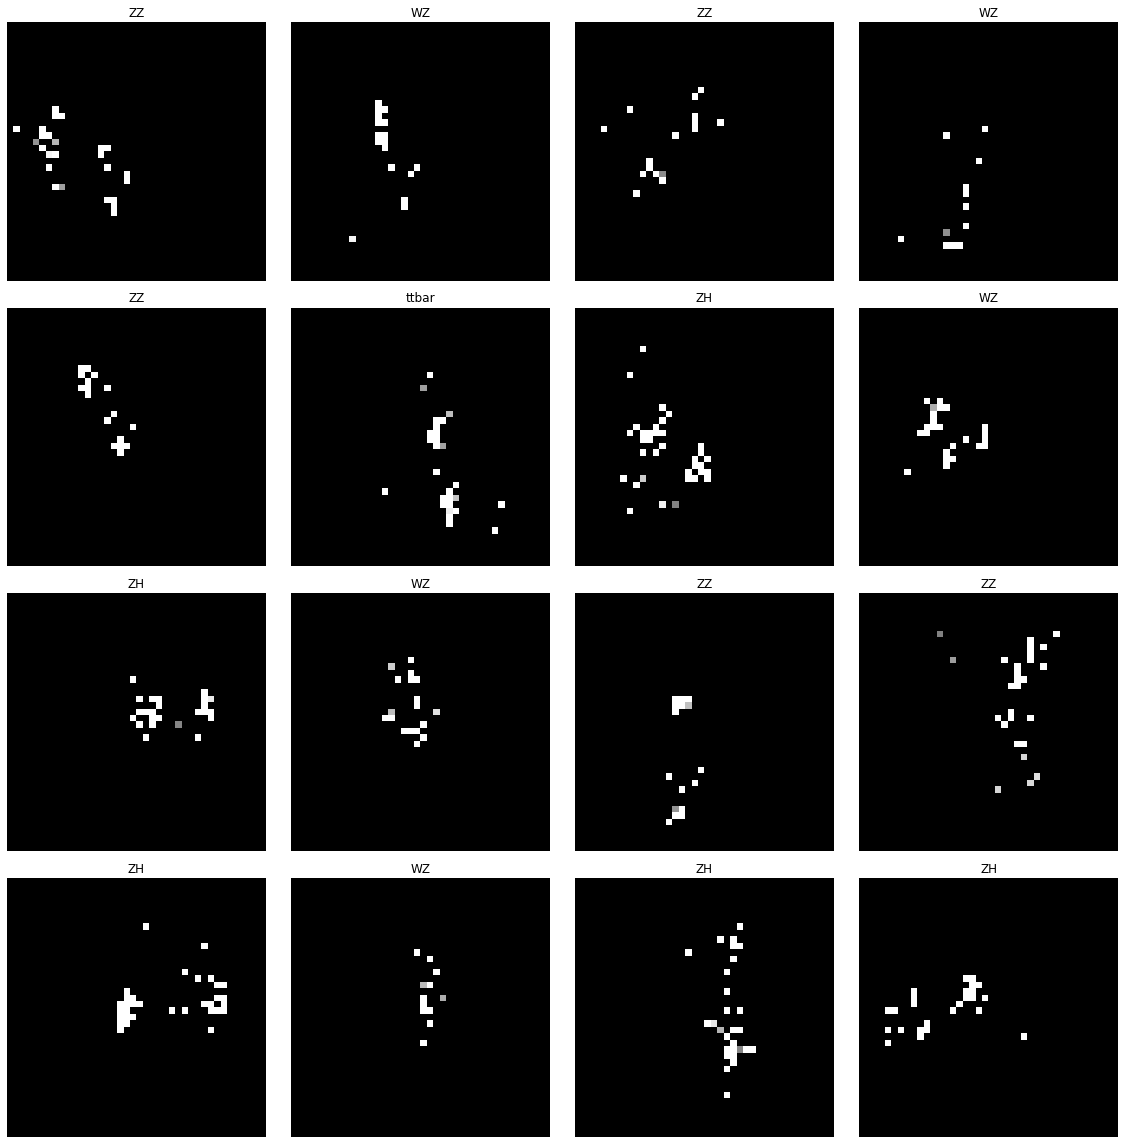

In [17]:
data.show_batch(4)

In [18]:
np.bincount(data.train_ds.y)

array([10782, 15596,  8438,  6384])

In [0]:
data.train_ds.classes

['WZ', 'ZH', 'ZZ', 'ttbar']

In [0]:
weighs = len(data.train_ds)/(data.c*np.bincount(data.train_ds.y))
class_weights = torch.FloatTensor(weighs).cuda()
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

# About the initialization problem:

https://pouannes.github.io/blog/initialization/

In [0]:
class Net(nn.Module):

    def __init__(self, num_classes=2):
        super(Net, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=0),#40,40 -> 20,20
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64*2, kernel_size=5, padding=2, stride=2),#20,20 -> 10,10
            nn.ReLU(inplace=True),
            nn.Conv2d(64*2, 64*4, kernel_size=3, padding=1,stride=2),#10,10 -> 5,5
            nn.ReLU(inplace=True),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((5,5))
        self.classifier = nn.Sequential(
            nn.Linear(64*8*5*5, 50),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(50, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 64*8*5*5)
        x = self.classifier(x)
        return x

In [0]:
def my_conv_model(pretrained=False):
    return Net()

In [0]:
learner = cnn_learner(data,my_conv_model,pretrained=False,metrics=accuracy,
                     loss_func=loss_fn)

In [29]:
learner.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 19, 19]         1,792      True      
______________________________________________________________________
ReLU                 [64, 19, 19]         0          False     
______________________________________________________________________
Conv2d               [128, 10, 10]        204,928    True      
______________________________________________________________________
ReLU                 [128, 10, 10]        0          False     
______________________________________________________________________
Conv2d               [256, 5, 5]          295,168    True      
______________________________________________________________________
ReLU                 [256, 5, 5]          0          False     
______________________________________________________________________
AdaptiveAvgPool2d    [256, 1, 1]          0          False     
___________________________________________________

In [30]:
learner.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,time
0,1.906191,1.509222,0.379126,01:45
1,1.634245,1.376389,0.419126,01:45
2,1.484779,1.438326,0.421262,01:46
3,1.404197,1.464938,0.412524,01:46
